In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
# for a start, let's use the imdb reviews dataset
from tensorflow.keras.datasets import imdb

In [34]:
def load_data(percentage_of_sentences=None):
    # Load the data
    (sentences_train, y_train), (sentences_test, y_test) = imdb.load_data()
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(sentences_train))
        sentences_train = sentences_train[:len_train]
        y_train = y_train[:len_train]
        
        len_test = int(percentage_of_sentences/100*len(sentences_test))
        sentences_test = sentences_test[:len_test]
        y_test = y_test[:len_test]
            
    # Load the {interger: word} representation
    word_to_id = imdb.get_word_index()
    word_to_id = {k:(v+3) for k,v in word_to_id.items()}
    for i, w in enumerate(['<PAD>', '<START>', '<UNK>', '<UNUSED>']):
        word_to_id[w] = i

    id_to_word = {v:k for k, v in word_to_id.items()}

    # Convert the list of integers to list of words (str)
    X_train = [' '.join([id_to_word[_] for _ in sentence[1:]]) for sentence in sentences_train]
    
    return X_train


### Just run this cell to load the data
data = load_data(percentage_of_sentences=10)

In [45]:
def get_X_y(sentence, length=40):
    '''
    returns a tuple containing:
    - a sentence (a string)
    - the word immediately following that sentence
    '''
    words = sentence.split()
    # return None if the sentence is too short
    if len(words) <= length:
        return None
    # pick a random part of the sentence
    first_word_idx = np.random.randint(0, len(words) - length)
    # build X (a part of the sentence) and y (the word immediately following X)
    X = words[first_word_idx : first_word_idx + length]
    y = words[first_word_idx + length]
    # return X and y
    return X, y

In [47]:
# check the output of the function
get_X_y(data[0])

(['big',
  'profile',
  'for',
  'the',
  'whole',
  'film',
  'but',
  'these',
  'children',
  'are',
  'amazing',
  'and',
  'should',
  'be',
  'praised',
  'for',
  'what',
  'they',
  'have',
  'done',
  "don't",
  'you',
  'think',
  'the',
  'whole',
  'story',
  'was',
  'so',
  'lovely',
  'because',
  'it',
  'was',
  'true',
  'and',
  'was',
  "someone's",
  'life',
  'after',
  'all',
  'that'],
 'was')

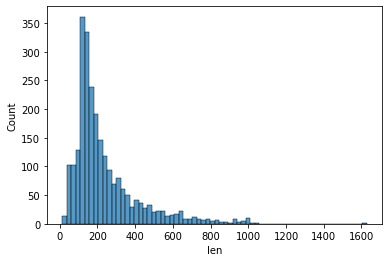

In [48]:
# check the number of words in the sentences in the dataset
df_word_count = pd.DataFrame({"len" : [len(s.split()) for s in data]})
sns.histplot(data=df_word_count, x="len");

In [49]:
def create_dataset(sentences, number_of_samples = 10000):
    '''
    creates a dataset (X and y) made of number_of_samples observations
    '''
    X, y = [], []
    indices = np.random.randint(0, len(sentences), size=number_of_samples)
    # call get_X_y number_of_samples times
    for idx in indices:
        ret = get_X_y(sentences[idx])
        if ret is None:
            continue
        xi, yi = ret
        X.append(xi)
        y.append(yi)
    return X, y

In [50]:
X, y = create_dataset(data)

In [51]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [52]:
len(X_train), len(X_test), len(y_train), len(y_test)

(6958, 2982, 6958, 2982)

In [53]:
X_train[:5]

[['that',
  'are',
  'a',
  'bit',
  'better',
  'however',
  'if',
  'anyone',
  'knows',
  'if',
  'these',
  'are',
  'much',
  'clearer',
  'it',
  'would',
  'be',
  'worth',
  'it',
  'to',
  'me',
  'to',
  'buy',
  'and',
  'share',
  'with',
  'my',
  'kids',
  'a',
  'great',
  'series',
  'clever',
  'scary',
  'and',
  'daringly',
  'supernatural',
  'thanks',
  'in',
  'advance',
  'to'],
 ['here',
  'she',
  'has',
  'a',
  'love',
  'scene',
  'with',
  'anthony',
  'john',
  'denison',
  'and',
  'also',
  'has',
  'a',
  'shower',
  'scene',
  'shot',
  'at',
  'a',
  'distance',
  'br',
  'br',
  'story',
  "we've",
  'seen',
  'this',
  'plot',
  'before',
  'a',
  'hundred',
  'times',
  'over',
  'and',
  'oftentimes',
  'done',
  'much',
  'better',
  'the',
  'true',
  'culprit'],
 ['a',
  'saturday',
  'evening',
  'br',
  'br',
  'sabrina',
  'is',
  'a',
  'young',
  'girl',
  'who',
  'moves',
  'in',
  'with',
  'her',
  'aunts',
  'who',
  'as',
  'it',
  '

In [54]:
y_train[:5]

['any', 'when', 'effectively', 'siege', 'of']

In [60]:
# create a dict containing tokens for all the words in X_train and y_train
token = 0
word_to_id = {"_unknown_" : token}
token += 1
for word in set(y_train):
    if word not in word_to_id:
        word_to_id[word] = token
        token += 1
for sentence in X_train:
    for word in set(sentence):
        if word not in word_to_id:
            word_to_id[word] = token
            token += 1

In [61]:
word_to_id

{'_unknown_': 0,
 'sight': 1,
 'title': 2,
 'drives': 3,
 'rob': 4,
 'sharon': 5,
 'enhancements': 6,
 'i': 7,
 'although': 8,
 'ludicrously': 9,
 'future': 10,
 'acts': 11,
 'faced': 12,
 'job': 13,
 'career': 14,
 'supernatural': 15,
 'brother': 16,
 'genius': 17,
 'new': 18,
 'harlem': 19,
 'rosebud': 20,
 'ha': 21,
 'than': 22,
 'refers': 23,
 'overplay': 24,
 'provides': 25,
 'producer': 26,
 'devil': 27,
 'spoiler': 28,
 'ridden': 29,
 'substance': 30,
 'sliced': 31,
 'lessons': 32,
 'recordings': 33,
 'tactics': 34,
 'strongest': 35,
 'grade': 36,
 'feed': 37,
 'rosenbaum': 38,
 'inspire': 39,
 'sexy': 40,
 'academy': 41,
 'evaluation': 42,
 'paid': 43,
 'priest': 44,
 'spinal': 45,
 'situation': 46,
 'yet': 47,
 'perfect': 48,
 'premise': 49,
 'stinks': 50,
 'eventually': 51,
 'over': 52,
 'ensue': 53,
 'mclaglen': 54,
 'conference': 55,
 'showed': 56,
 'walker': 57,
 'overheating': 58,
 'allison': 59,
 'happens': 60,
 'bell': 61,
 'understand': 62,
 'wallace': 63,
 'mind': 64,

In [63]:
len(word_to_id) # /!\ There are too many different words !!!

18040

In [64]:
# tokenise X
X_train_tokenized = [[word_to_id.get(word, 0) for word in sentence] for sentence in X_train]
X_test_tokenized = [[word_to_id.get(word, 0) for word in sentence] for sentence in X_test]
X_train_tokenized = np.array(X_train_tokenized)
X_test_tokenized = np.array(X_test_tokenized)

In [65]:
# tokenise y
y_train_tokenized = [word_to_id.get(word, 0) for word in y_train]
y_test_tokenized = [word_to_id.get(word, 0) for word in y_test]
y_train_tokenized = to_categorical(y_train_tokenized, num_classes=len(word_to_id)) # /!\ too many classes
y_test_tokenized = to_categorical(y_test_tokenized, num_classes=len(word_to_id)) # /!\ too many classes

In [66]:
# build a model
def init_model(vocab_size):
    # create model
    model = Sequential()
    # add layers
    model.add(Embedding(input_dim=vocab_size, output_dim=32))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

model = init_model(len(word_to_id))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          577280    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 18040)             595320    
                                                                 
Total params: 1,181,976
Trainable params: 1,181,976
Non-trainable params: 0
_________________________________________________________________


In [67]:
# configure early stopping and fit the model
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
history = model.fit(X_train_tokenized,
                    y_train_tokenized,
                    epochs=100, 
                    batch_size=16,
                    callbacks=[es],
                    validation_split=0.3)

Epoch 1/100


2022-06-27 12:46:49.711765: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 351419200 exceeds 10% of free system memory.


304/305 [============================>.] - ETA: 0s - loss: 7.6555 - accuracy: 0.0477

2022-06-27 12:46:58.339617: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150670080 exceeds 10% of free system memory.


305/305 [==============================] - 10s 27ms/step - loss: 7.6541 - accuracy: 0.0476 - val_loss: 7.2251 - val_accuracy: 0.0560
Epoch 2/100
305/305 [==============================] - 7s 23ms/step - loss: 6.7321 - accuracy: 0.0511 - val_loss: 7.1845 - val_accuracy: 0.0560
Epoch 3/100
305/305 [==============================] - 7s 23ms/step - loss: 6.5614 - accuracy: 0.0511 - val_loss: 7.2980 - val_accuracy: 0.0560
Epoch 4/100
305/305 [==============================] - 7s 23ms/step - loss: 6.4375 - accuracy: 0.0511 - val_loss: 7.3234 - val_accuracy: 0.0560
Epoch 5/100
305/305 [==============================] - 7s 23ms/step - loss: 6.3545 - accuracy: 0.0511 - val_loss: 7.3728 - val_accuracy: 0.0560


In [68]:
model.evaluate(X_test_tokenized, y_test_tokenized)

11/94 [==>...........................] - ETA: 0s - loss: 7.2578 - accuracy: 0.0455

2022-06-27 12:47:38.101287: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 215181120 exceeds 10% of free system memory.


94/94 [==============================] - 1s 10ms/step - loss: 7.2445 - accuracy: 0.0540


[7.2445244789123535, 0.05399060994386673]

In [73]:
# test the model

id_to_word = {val : key for key, val in word_to_id.items()}

def get_predicted_word(string):
    # tokenise the string
    sentence = string.split()
    X_tokenized = [word_to_id.get(word, 0) for word in sentence]
    # make prediction
    y_pred = model.predict([X_tokenized])
    # only keep max of softmax
    y_pred_token = np.argmax(y_pred[0])
    # change token back to letter
    y_pred_letter = id_to_word[y_pred_token]
    return y_pred_letter

string = "this is a good movie and i think the actors"

get_predicted_word(string)

1/1 [==============================] - 0s 30ms/step


'the'

In [75]:
# repeat the predictions to make words and sentences

def repeat_prediction(string, repetition=10):
    string_tmp = string
    for i in range(repetition):
        string_tmp += " " + get_predicted_word(string_tmp)
    return string_tmp

string = "this is a good movie and i think the actors"

repeat_prediction(string, 20)

1/1 [==============================] - 0s 27ms/step


'this is a good movie and i think the actors the the the the the the the the the the the the the the the the the the the the'

In [77]:
# Obviously this model doesn't work and always predict the word "the".
# But at we now have a first draft and a baseline to start from.
# This is most likely because the word "the" appears too often in the training data
# and because there are way too many different words in the training data.
# Also, the tokenizing method completely looses the information about the meaning of the words.